In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys


FOLDER_PATH = 'Colab Notebooks/Pedro-Londono_CW_Folder/'

MODELS_PATH = 'Colab Notebooks/Pedro-Londono_CW_Folder/Models'

GOOGLE_FOLDER_PATH = os.path.join('drive', 'My Drive', FOLDER_PATH)
GOOGLE_MODELS_PATH = os.path.join('drive', 'My Drive', MODELS_PATH)
sys.path.append(GOOGLE_MODELS_PATH)
print(os.listdir(GOOGLE_MODELS_PATH))
print(os.listdir(GOOGLE_FOLDER_PATH))

['CNN.ipynb', 'SVM_Model.py', '__pycache__', 'HOG-SVM.ipynb', 'MLP.ipynb', 'SIFT-BoW-SVM.ipynb', 'HOG-BoW-SVM.ipynb', 'SVC_Alone.ipynb', 'HOG-MLP.ipynb']
['Models', 'test_function.ipynb', 'CW_Dataset', 'svc_alone.joblib', 'svc_hog.joblib', 'variables', 'assets', 'knn.joblib', 'svc_sift.joblib', 'cnn_arc1.h5', 'kmeans.joblib', 'mlp_arc1.h5', 'mlp_arc2.h5', 'cnn_arc2.h5', 'hog_mlp_arc1.h5', 'Personal_Dataset']


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 84kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [5]:
import cv2
from skimage import img_as_ubyte, io, color
import numpy as np
import matplotlib.pyplot as plt

DATASET_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'CW_Dataset')
PERSONAL_DATASET_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'Personal_Dataset')

def load_images_from_folder(path, label_list=None):
  """Loads images from folders"""
  images = []
  labels = []
  img_labels = {}

  if label_list is None:
    folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('README')]
    print('folder_names', folder_names)
  else:
    folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list.endswith('.jpg')]  
  
  for folder in folder_names:
    file_names = [file for file in sorted(os.listdir(os.path.join(path, folder)))]
    print('file_names', file_names)
    for file in file_names:
      
      if file.endswith('.txt'):
        labels_rd = np.loadtxt(os.path.join(path, folder, file), delimiter=' ', usecols=(1)).tolist()

        [labels.append(label) for label in labels_rd]
        print(labels[:5], len(labels))
        
        print(folder, file, labels)
      else:
        rep_str = '(1)'
        if rep_str not in file:
          images.append(io.imread(os.path.join(path, folder, file)))
        print(folder, file)
  return images, labels


In [6]:

def convert_to_numpy(images, labels):
  """Converts the images to a numpy array""" 
  
  data = np.asarray(images)
  lb = np.asarray(labels)
  return data, lb



In [7]:
import tensorflow as tf
import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from skimage import img_as_ubyte, color
from skimage.transform import rescale, resize
from sklearn.externals import joblib
from skimage.feature import hog
from SVM_Model import SVM_Model
from keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [15]:
def preprocess(X, y):
  X, y = convert_to_numpy(X, y)  
  X = X / 255.
  y = y.astype(int)
  X = img_as_ubyte(color.rgb2gray(X))
  
  return X, y



def crossvalidate(X, y):
  """Splits the data into crossvalidation"""
  skf = StratifiedKFold(n_splits=5)
  for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

  return X_train, X_test, y_train, y_test

def hog_preprocessing(X_test):
  """Extracts features using HOGs"""
  HOG_des_list = []

  #extract features from every image in the test set using HOGs
  for i in range(len(X_test)):
      HOG_des, HOG_image = hog(X_test[i, :, :], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)  

      if HOG_des is not None:
        HOG_des_list.append(HOG_des)  

  #convert the data to numpy array  
  HOG_des_list = np.asarray(HOG_des_list)


  return HOG_des_list

def sift_preprocessing(X_test, y_test):
  """Extracts features using SIFT"""
  #create SIFT feature extractor
  sift = cv2.SIFT_create()
  hist_list = []

  #load pre-trained k-means algorithm
  KMEANS_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'kmeans.joblib')
  kmeans = joblib.load(KMEANS_PATH)

  k = len(np.unique(y_test)) * 10
  #extract features from every image in the test set using SIFT
  for i in range(len(X_test)):
      img = X_test[i, :, :]
      kp, des = sift.detectAndCompute(img, None)

      if des is not None:
          hist = np.zeros(k)

          idx = kmeans.predict(des)
          
          for j in idx:
              hist[j] = hist[j] + (1 / len(des))

          # hist = scale.transform(hist.reshape(1, -1))
          hist_list.append(hist)

      else:
          hist_list.append(None)


  # Remove potential cases of images with no descriptors
  idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
  hist_list = [hist_list[i] for i in idx_not_empty]
  
  y_test = np.asarray([y_test[i] for i in idx_not_empty])
  X_test_img = np.asarray([X_test[i, :, :] for i in idx_not_empty])
  hist_array = np.vstack(hist_list)
  
  return hist_array, y_test, X_test_img
  
def test_data(X_test, y_test, model_type):
    """Select X_test and y_test based on different models"""
    
    X_test_img = X_test.reshape(-1, 100, 100)

    if 'cnn' in model_type:
      X_test = np.expand_dims(X_test, -1)
      y_test = to_categorical(y_test, num_classes=8)
      
    elif 'mlp' in model_type:
      if 'hog' in model_type:
        print(X_test.shape)
        X_test = hog_preprocessing(X_test)
      elif 'sift' in model_type:
        X_test, y_test, X_test_img = sift_preprocessing(X_test, y_test)
        #X_test_img = X_test
        print(X_test_img.shape, X_test.shape, y_test.shape)
      else:
        X_test = X_test.reshape(-1, 100*100)
      
      y_test = to_categorical(y_test, num_classes=8)
    

    elif 'svc' in model_type:
      if 'hog' in model_type:
        print(X_test.shape)
        X_test = hog_preprocessing(X_test)
      elif 'sift' in model_type:
        X_test, y_test, X_test_img = sift_preprocessing(X_test, y_test)
        #X_test_img = X_test
        print(X_test_img.shape, X_test.shape, y_test.shape)
      else:
        X_test = X_test.reshape(-1, 100*100)
    
    return X_test, y_test, X_test_img

def show_results(X_test, y_test, y_pred):
    """Compares the predictions and true labels of the images"""
    X_test, y_test, y_pred = shuffle(X_test,  y_test, y_pred)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 6), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(4):
        ax[i].imshow(X_test[i, :, :], cmap='gray')
        ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()   

In [12]:
#from joblib import load
from sklearn.externals import joblib
from sklearn.utils import shuffle

def EmotionRecognition(path_to_testset, model_type):
    # load images from the dataset path
    X, y = load_images_from_folder(path_to_testset)

   # preprocess images
    X, y = preprocess(X, y)
    _, X_test, _, y_test = crossvalidate(X, y)

    
   #select the testing data based on the different algorithms 
    X_test, y_test, X_test_img = test_data(X_test, y_test, model_type)

    #select type model
    if model_type == 'svc_alone':
      SVC_ALONE_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'svc_alone.joblib')
      model = joblib.load(SVC_ALONE_PATH)
      
    elif model_type == 'svc_hog':
      SVC_HOG_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'svc_hog.joblib')
      model = joblib.load(SVC_HOG_PATH)

    elif model_type == 'hog_mlp_arc1':
      HOG_MLP_ARC1_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'hog_mlp_arc1.h5')
      model = keras.models.load_model(HOG_MLP_ARC1_PATH)
    elif model_type == 'svc_sift':
      SVC_SIFT_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'svc_sift.joblib')
      model = joblib.load(SVC_SIFT_PATH)
      
    elif model_type == 'mlp_arc1':
      MLP_ARC1_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'mlp_arc1.h5')
      model = keras.models.load_model(MLP_ARC1_PATH)
      
      print(f'y_test shape: {y_test.shape}')

    elif model_type == 'mlp_arc2':
      MLP_ARC2_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'mlp_arc2.h5')
      model = keras.models.load_model(MLP_ARC2_PATH)
      
      print(f'y_test shape: {y_test.shape}')

    elif model_type == 'cnn_arc1':
      CNN_ARC1_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'cnn_arc1.h5')
      model = keras.models.load_model(CNN_ARC1_PATH)

    elif model_type == 'cnn_arc2':
      CNN_ARC2_PATH = os.path.join(GOOGLE_FOLDER_PATH, 'cnn_arc2.h5')
      model = keras.models.load_model(CNN_ARC2_PATH)
      
    print(X_test.shape)
    y_pred = model.predict(X_test)

    #convert back to ordinal encoding   
    if 'cnn' in model_type or 'mlp' in model_type:
      y_test = [np.argmax(y) for y in y_test[:, :]]

      y_pred = [np.argmax(y_p) for y_p in y_pred[:, :]]
     
    show_results(X_test_img, y_test, y_pred)
  


## Coursework Dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07294_aligned.jpg
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train

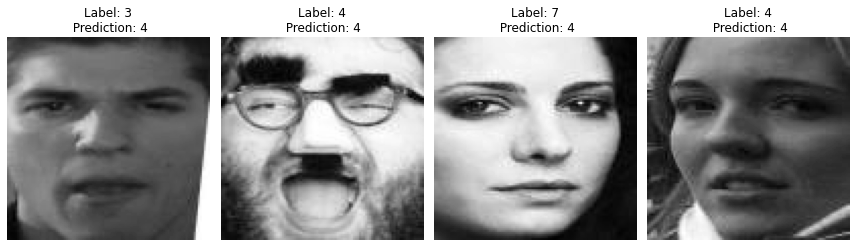

In [16]:
EmotionRecognition(DATASET_PATH, 'svc_alone')

#### Hog Descriptor using different models

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train train_07324_aligned.jpg
train

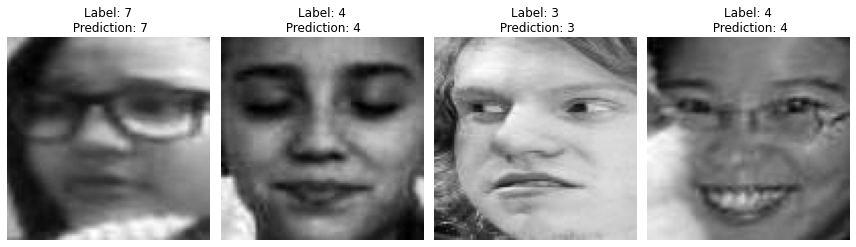

In [17]:
EmotionRecognition(DATASET_PATH, 'svc_hog')

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train train_07324_aligned.jpg
train

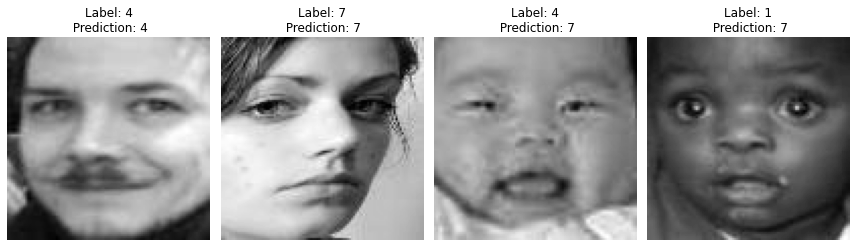

In [18]:
EmotionRecognition(DATASET_PATH, 'hog_mlp_arc1')

#### SIFT descriptor using different models

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train train_07324_aligned.jpg
train

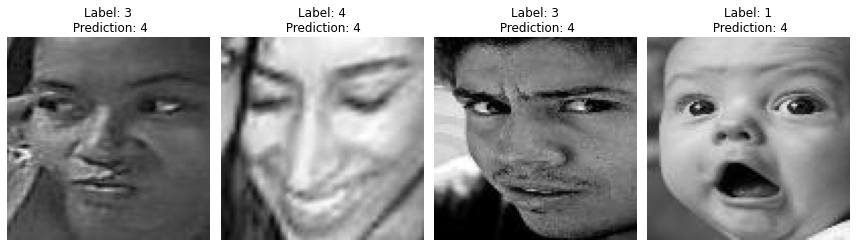

In [19]:
EmotionRecognition(DATASET_PATH, 'svc_sift')

#### Multilayer Perceptron

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train train_07324_aligned.jpg
train

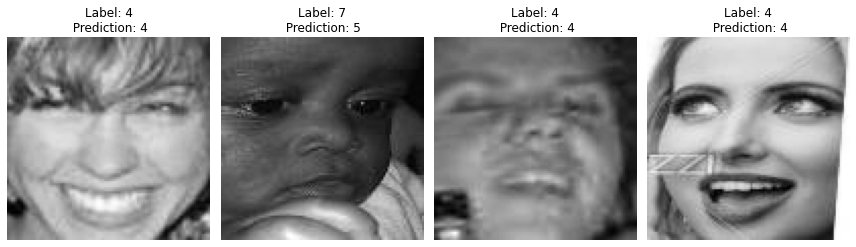

In [20]:
EmotionRecognition(DATASET_PATH, 'mlp_arc1')

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train train_07324_aligned.jpg
train

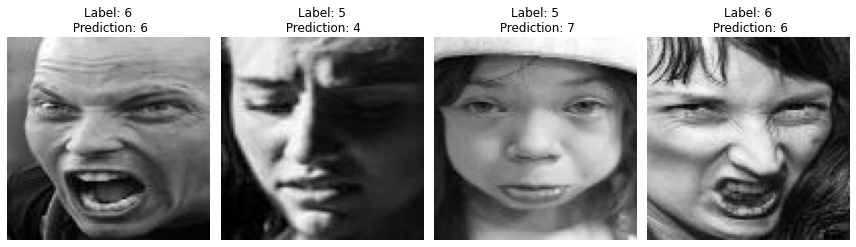

In [21]:
EmotionRecognition(DATASET_PATH, 'mlp_arc2')

#### Convolutional Neural Network

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07294_aligned.jpg
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train

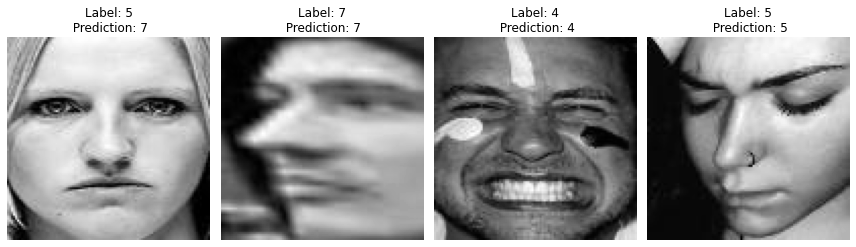

In [22]:
EmotionRecognition(DATASET_PATH, 'cnn_arc1')

Se han truncado las últimas 5000 líneas del flujo de salida.
train train_07294_aligned.jpg
train train_07295_aligned.jpg
train train_07296_aligned.jpg
train train_07297_aligned.jpg
train train_07298_aligned.jpg
train train_07299_aligned.jpg
train train_07300_aligned.jpg
train train_07301_aligned.jpg
train train_07302_aligned.jpg
train train_07303_aligned (1).jpg
train train_07303_aligned.jpg
train train_07304_aligned.jpg
train train_07305_aligned.jpg
train train_07306_aligned.jpg
train train_07307_aligned.jpg
train train_07308_aligned.jpg
train train_07309_aligned.jpg
train train_07310_aligned.jpg
train train_07311_aligned.jpg
train train_07312_aligned.jpg
train train_07313_aligned.jpg
train train_07314_aligned.jpg
train train_07315_aligned.jpg
train train_07316_aligned.jpg
train train_07317_aligned.jpg
train train_07318_aligned.jpg
train train_07319_aligned.jpg
train train_07320_aligned.jpg
train train_07321_aligned.jpg
train train_07322_aligned.jpg
train train_07323_aligned.jpg
train

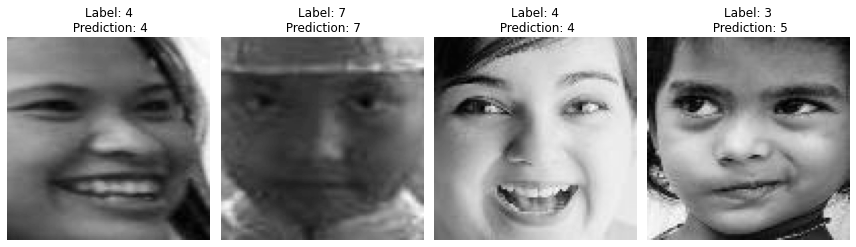

In [23]:
EmotionRecognition(DATASET_PATH, 'cnn_arc2')

## Personal Dataset

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

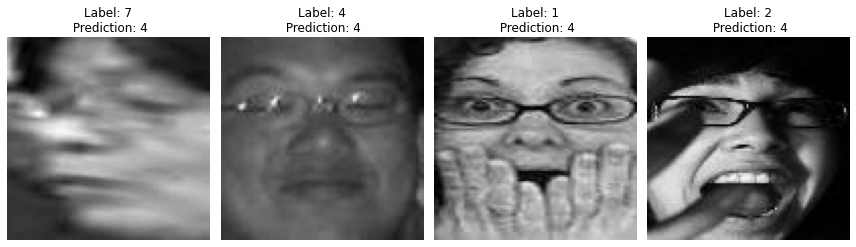

In [24]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'svc_alone')

#### Hog Descriptor using different models

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

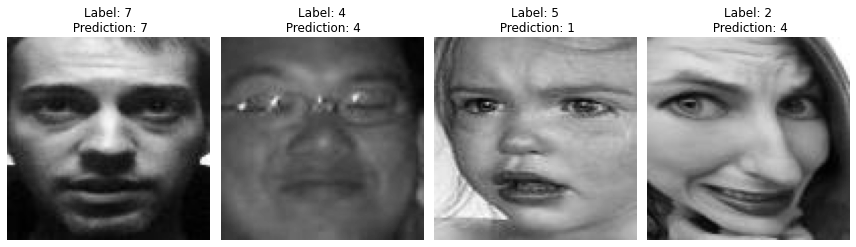

In [25]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'svc_hog')

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

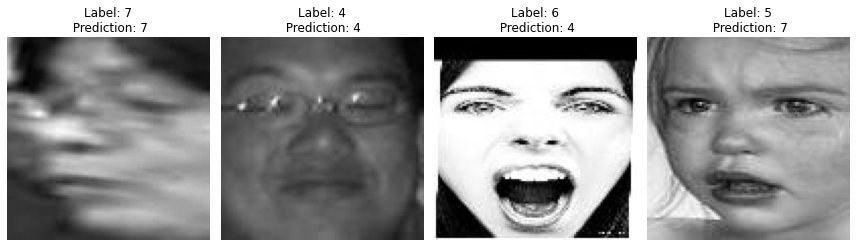

In [26]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'hog_mlp_arc1')

#### SIFT descriptor using different models

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

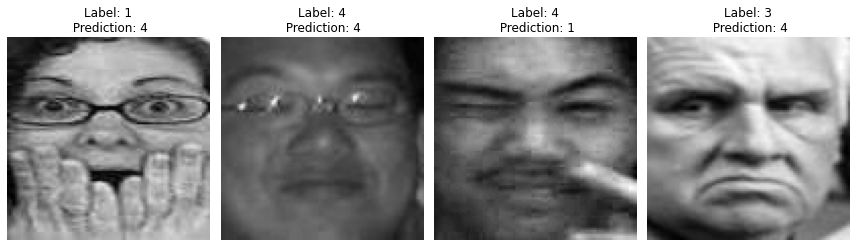

In [27]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'svc_sift')

#### Multilayer Perceptron

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

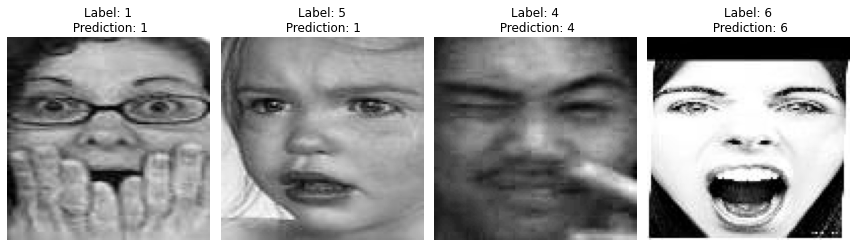

In [28]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'mlp_arc1')

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

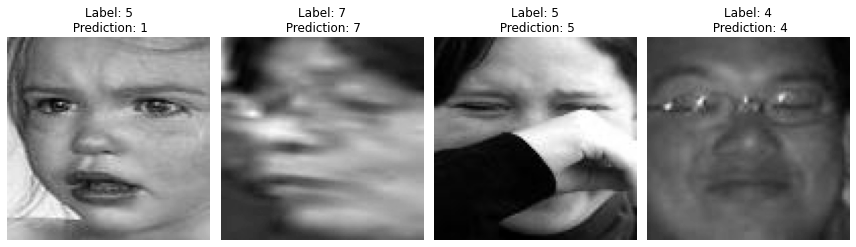

In [29]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'mlp_arc2')

#### Convolutional Neural Network

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

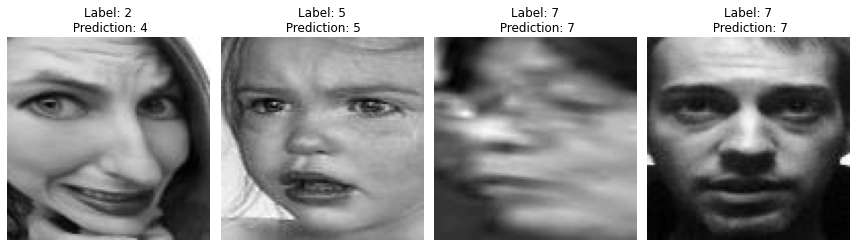

In [30]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'cnn_arc1')

folder_names ['labels', 'test', 'train']
file_names ['list_label_test.txt', 'list_label_train.txt']
[1.0, 1.0, 1.0, 1.0, 2.0] 28
labels list_label_test.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
[1.0, 1.0, 1.0, 1.0, 2.0] 56
labels list_label_train.txt [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0]
file_names ['test_001.jpg', 'test_002.jpg', 'test_003.jpg', 'test_004.jpg', 'test_005.jpg', 'test_006.jpg', 'test_007.jpg', 'test_008.jpg', 'test_009.jpg', 'test_010.jpg', 'test_011.jpg', 'test_012.jpg', 'test_013.jpg', 'test_014.jpg', 'test_015.jpg', 'test_016.jpg', 'test_017.jpg', 'test_018.jpg', 'test_019.jpg', 'test_020.jpg', 'test_021.jpg', 'test_022.jpg', '

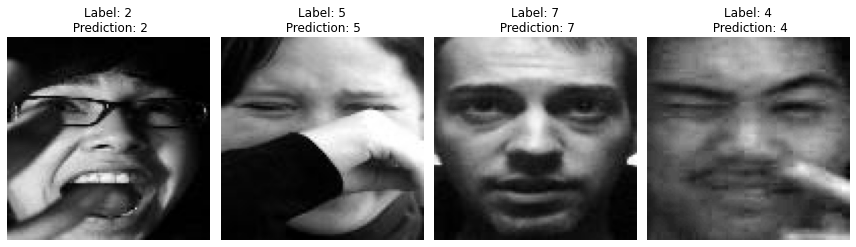

In [31]:
EmotionRecognition(PERSONAL_DATASET_PATH, 'cnn_arc2')